# BART



### 0. Setup BART on Google Colab

This cell will setup BART on Google Colab. For a detailed explanation, see **How to Run BART on Google Colaboratory** in the repository for the [ISMRM 2021](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2021). You can skip this part if you want to run this notebook on Binder or your local machine with BART already installed.

In [1]:
%%bash

# Install BARTs dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev bc


Reading package lists...
Building dependency tree...
Reading state information...
bc is already the newest version (1.07.1-2).
libfftw3-dev is already the newest version (3.3.7-1).
liblapacke-dev is already the newest version (3.7.1-4ubuntu1).
make is already the newest version (4.1-9.1ubuntu1).
libopenblas-dev is already the newest version (0.2.20+ds-4).
gcc is already the newest version (4:7.4.0-1ubuntu2.3).
libpng-dev is already the newest version (1.6.34-1ubuntu0.18.04.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


Clone BART source code repository from github.

In [2]:
%%bash

# Clone Bart
[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart

cd bart

# checkout version 0.8.00
git checkout v0.8.00


Cloning into 'bart'...
Note: checking out 'v0.8.00'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at eacc67b9 bump version


In [6]:
%%bash

cd bart

# Compile BART
PARALLEL=1 make &> /dev/null

In [7]:
import os
import sys

# Define environment variables for BART and OpenMP

os.environ['TOOLBOX_PATH'] = "/content/bart"

# Add the BARTs toolbox to the PATH variable

os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python")

#### Check BART version

In [8]:
%%bash

echo "# The BART used in this notebook:"
which bart
echo "# BART version: "
bart version

# The BART used in this notebook:
/content/bart/bart
# BART version: 
v0.8.00


### Function for Displaying an Image

In [9]:
import sys
import os
sys.path.insert(0, os.path.join(os.environ['TOOLBOX_PATH'], 'python'))
import cfl

import numpy as np
import matplotlib.pyplot as plt

def imshow(img):
    plt.imshow(np.abs(img.squeeze()))

Create oversampled radial trajectory:


In [10]:
! bart traj -r -y55 -x128 -o2. trajectory

Simulate k-space data:


In [11]:
! bart phantom -t trajectory -k kspace

Look at the header file:

In [12]:
! cat kspace.hdr

# Dimensions
1 256 55 1 1 1 1 1 1 1 1 1 1 1 1 1 
# Command
phantom -t trajectory -k kspace 
# Files
 >kspace <trajectory
# Creator
BART v0.8.00


Fourier transform along radial spoke and show sinogram.

Apply inverse Fourier transform:

In [13]:
! bart fft -i $(bart bitmask 0 1) kspace sinogram

Show the reconstructed image:

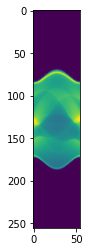

In [14]:
imshow(cfl.readcfl('sinogram'))

Compute Ram-Lak filter and apply to kspace.

In [16]:
! bart rss 1 trajectory ramlak
! bart fmac kspace ramlak kspace_dcf

Apply adjoint nufft (gridding) and show result.



In [18]:
! bart nufft -a trajectory kspace_dcf image

Est. image size: 128x128x1
Done.


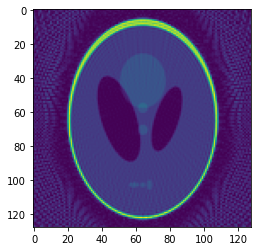

In [19]:
imshow(cfl.readcfl('image'))

In [20]:
%%bash
rm *.{hdr,cfl}